# Example of Clustering Validation using External Measures
In this example, we apply hierarchical clustering to the input variables of the Iris dataset. Then, we evaluate the solution using internal measures (by computing WSS and BSS) and external measures (by comparing the labels assigned by the clustering with the known labels).

We begin by importing the needed libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

We load the Iris data set and print some statistics.

In [2]:
iris = datasets.load_iris()
target = np.array(iris.target)

print("Number of examples: ", iris.data.shape[0])
print("Number of variables:", iris.data.shape[1])
print("Variable names:     ", iris.feature_names)
print("Target values:      ", iris.target_names)
print("Class Distribution  ", [(x,sum(target==x)) for x in np.unique(target)])

Number of examples:  150
Number of variables: 4
Variable names:      ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target values:       ['setosa' 'versicolor' 'virginica']
Class Distribution   [(0, 50), (1, 50), (2, 50)]


We apply hierarchical clustering using single linkage. Given that there are 150 cases, we have 149 merges.

In [3]:
merges = linkage(iris.data, method = 'single')
print('there have been %d merges'%(merges.shape[0]))

there have been 149 merges


Let's plot the dendrogram which shows two major clusters: a smaller one (in green) and a larger one.

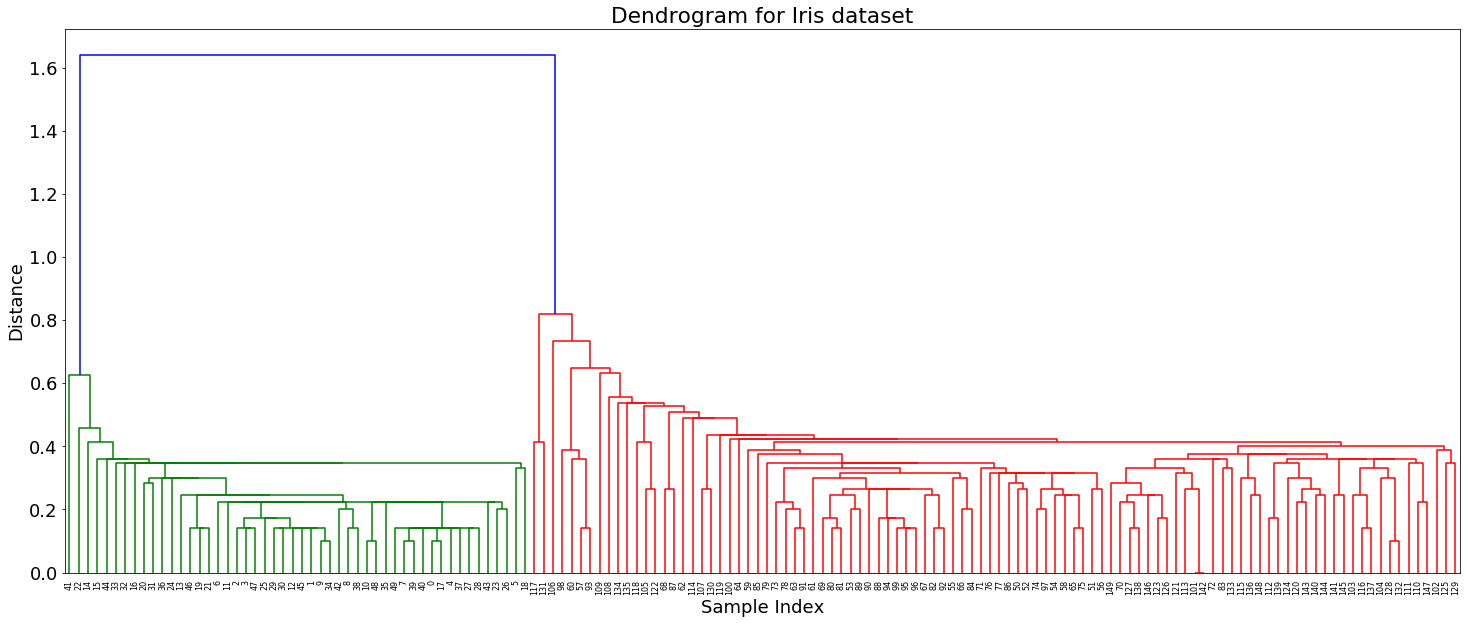

In [4]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(merges, 
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.title('Dendrogram for Iris dataset')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## Internal Measures
We evaluate the possible clustering by analyzing the withing sum of squares (WSS) and the between sum of squares of the different clustering solutions.


In [5]:
def ComputeInternalMeasures(x, merges, k_values):
    wss_values = {}
    bss_values = {}

    for k in k_values:
        clustering = fcluster(merges, k, criterion='maxclust')
        centroids = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
        cdist(x, centroids, 'euclidean')
        D = cdist(x, centroids, 'euclidean')
        cIdx = np.argmin(D,axis=1)
        d = np.min(D,axis=1)

        avgWithinSS = sum(d)/x.shape[0]

        # Total with-in sum of square
        wss = sum(d**2)

        tss = sum(pdist(x)**2)/x.shape[0]

        bss = tss-wss

        wss_values[k] = wss
        bss_values[k] = bss
    return wss_values,bss_values

In [6]:
k_values = range(1,20)
wss_dict, bss_dict = ComputeInternalMeasures(iris.data, merges, k_values)

In [7]:
wss_values = [wss_dict[x] for x in range(1,20)]
bss_values = [bss_dict[x] for x in range(1,20)]

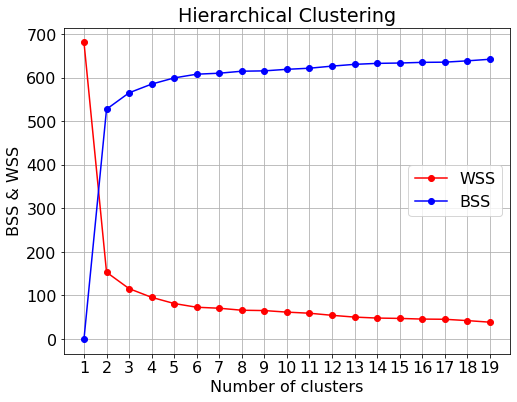

In [8]:
fig = plt.figure(figsize=(8,6))
font = {'family' : 'sans', 'size'   : 16}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

There is a clear elbow around k=2 but we cannot just select two clusters. We should use the elbow as a guide but test multiple solutions around that value. 

## External Meaures
Let's evaluate the solution with three clusters and compute a table that report the distribution of original labels in each one of the three clusters so that we can compare the clustering solution against the known labels.

In [9]:
labels_single_k3 = fcluster(merges,3,criterion='maxclust')
# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels_single_k3, 'varieties': iris.target_names[target]})

# Create crosstab: ct
ct = pd.crosstab(df['labels'],df['varieties'])

# Print the table
print(ct)

varieties  setosa  versicolor  virginica
labels                                  
1              50           0          0
2               0           0          2
3               0          50         48


In [10]:
labels_single_k4 = fcluster(merges,4,criterion='maxclust')
# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels_single_k4, 'varieties': iris.target_names[target]})

# Create crosstab: ct
ct = pd.crosstab(df['labels'],df['varieties'])

# Print the table
print(ct)

varieties  setosa  versicolor  virginica
labels                                  
1              50           0          0
2               0           0          2
3               0          50         47
4               0           0          1


Note that cluster 1 perfectly identifies all the examples labeled as "setosa", Cluster 2 contains just two examples (labeled "virginica"), while Cluster 3 contains all the remaining cases.

What happens when we use complete linkage or average linkage?

In [11]:
# Repeats the analysis using complete linkage

merges = linkage(iris.data, method = 'complete')
labels = fcluster(merges,3,criterion='maxclust')
# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': iris.target_names[target]})

# Create crosstab: ct
ct = pd.crosstab(df['labels'],df['varieties'])

# Print the table
print(ct)

varieties  setosa  versicolor  virginica
labels                                  
1               0          23         49
2               0          27          1
3              50           0          0


In [12]:
# Repeats the analysis using average linkage

merges = linkage(iris.data, method = 'average')
labels = fcluster(merges,3,criterion='maxclust')
# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': iris.target_names[target]})

# Create crosstab: ct
ct = pd.crosstab(df['labels'],df['varieties'])

# Print the table
print(ct)

varieties  setosa  versicolor  virginica
labels                                  
1              50           0          0
2               0           0         36
3               0          50         14


## How Can We Represent Clusters?
Hierarchical clustering produces as a result a hierarchy of partitions. Using either an internal or an external measure we can select the most appropriate number of clusters. Finally, we can assign the cluster labels to the examples. 

But how can we present the clusters to our customers? 

Hierarchical clustering produces a single column of cluster labels. But we cannot present just the labels we need to find a way to summarize the result. We need to build "cluster personas".

Suppose that we use the last clustering obtained using <b>single linkage</b> with three and four clusters. We can generate a summary of this solution by print the average values of all the features for each cluster.

In [13]:
df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
df_iris['cluster']=labels_single_k3
df_iris.groupby('cluster').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
1,5.006000,3.428000,1.462000,0.246000
2,7.800000,3.800000,6.550000,2.100000
3,6.230612,2.853061,4.872449,1.667347


In [14]:
df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
df_iris['cluster']=labels_single_k4
df_iris.groupby('cluster').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
1,5.00600,3.428000,1.462000,0.24600
2,7.80000,3.800000,6.550000,2.10000
3,6.24433,2.856701,4.876289,1.66701
4,4.90000,2.500000,4.500000,1.70000


Given the statistics, we need to build a narrative that can characterize the clustering solution we selected. Such narrative is typically created using "cluster personas", profiles that describe the main features of the clusters.

## Snake Plots
These are market research techniques used to compare different segments. They provide a visual representation of each segment attributes. First, the data are normalized (according to the mean and the standard deviation) then we plot each cluster's average normalized values of each attribute.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

normalized_iris = scaler.fit_transform(iris.data)
df_iris_normalized = pd.DataFrame(normalized_iris,columns=iris.feature_names)
df_iris_normalized['cluster'] = labels_single_k4

In [16]:
df_iris_melt = pd.melt(df_iris_normalized, 
                    id_vars=['cluster'],
                    value_vars=iris.feature_names, 
                    var_name='Attribute', 
                    value_name='Value')

In [17]:
import seaborn as sns

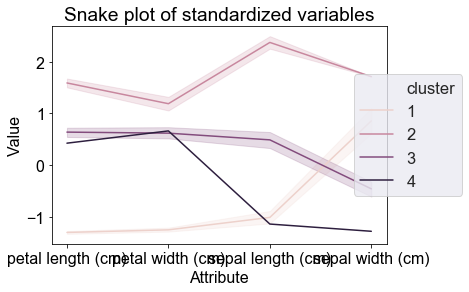

In [18]:
plt.title('Snake plot of standardized variables')
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.lineplot(x="Attribute", y="Value", hue='cluster', data=df_iris_melt)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)